<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>SVM, Kernel Trick (практика)</center></h2>

**Срок сдачи:** 24 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 24 апреля, -4 балла после 06:00 1 мая, -6 баллов после 06:00 8 мая

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Levenshtein import distance
from tqdm import tqdm_notebook
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Семинарская часть

Функция `select_model` принимает на вход обучающую выборку и возвращает модель (машину опорных векторов) с наилучшими параметрами для данной выборки. Эту функцию нужно реализовать.

Подбираемые параметры подели включают в себя:
- различные функции ядра (линейное, RBF, полиномиальные разных степеней)
- различные значения константы $C$ ($0, 0.1, 1, 10, 100, 1000, 10000$)

Подбирать параметры необходимо с помощью 10-fold кросс-валидации. Сейчас в качестве заглушки функция всегда возвращает линейный SVC.

In [ ]:
def select_model(x, y):
    """
    Implement some model selection strategy here:
    seek through different kernels and parameters.

    Use a validation scheme to select the best model
    
    Quality metric: accuracy

    Returns:
        SVM classifier implemented by sklearn SVC class.
    """
    best_accuracy = 0
    best_model = None
    
    kernel = 'linear'

    model = SVC(kernel=kernel)
    print "Trying model {}".format(model)
    
    accuracy = np.mean(cross_val_score(model, x, y))

    best_model = model
    best_accuracy = accuracy
    
    best_model.fit(x, y)
    print "Best model %s, with accuracy %f" % (best_model, best_accuracy)
    return best_model

Далее две вспомогательные функции, которые отображают данные и разделяющую поверхность

In [ ]:
def plot_data_set(x, y, description=''):
    print "Plotting data set points"
    plt.figure(figsize=(8, 8))

    colors = np.array(['r', 'b'])[y]
    plt.title(description, fontsize='small')
    plt.scatter(x[:, 0], x[:, 1], marker='o', c=colors, s=50)
    
def plot_decision_region(x1_min, x2_min, x1_max, x2_max, clf, n_points=1000):
    print "Plotting decision region"
    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n_points), np.linspace(x2_min, x2_max, n_points))
    z = clf.decision_function(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)

    plt.contour(x1, x2, z, levels=[0.0], linestyles='solid', linewidths=2.0)
    plt.contour(x1, x2, z, levels=[-1.0, 1.0], linestyles='dashed', linewidths=1.0)

In [ ]:
def generate_linear(size=100, k=1.1, b=0.0, nl=0.1):
    print "Generating 'Linearly-separated' data set"

    x = np.random.random((size, 2))
    y = np.zeros(size, dtype=int)
    noise = np.random.randn(size) * nl
    y[x[:, 1] - (k * x[:, 0] + b) > noise] = 1

    return x, y

x, y = generate_linear()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

In [ ]:
def generate_concentric(size=100, r1=1.0, r2=2.0, sigma=0.3):
    print "Generating 'Concentric circles' data set"
    x = np.zeros((size, 2))
    x[:size/2, 0] = sigma * np.random.randn(size/2) + r1
    x[size/2:, 0] = sigma * np.random.randn(size/2) + r2
    x[:, 1] = (np.random.random(size) - 0.5) * 2 * np.pi
    y = np.hstack([np.zeros(size/2, dtype=int), np.ones(size/2, dtype=int)])

    z = np.zeros((size, 2))
    z[:, 0] = x[:, 0] * np.cos(x[:, 1])
    z[:, 1] = x[:, 0] * np.sin(x[:, 1])

    return z, y

x, y = generate_concentric()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

In [ ]:
def generate_sin(size=200):
    print "Generating 'Sinus-separated' data set"

    x = np.random.random((size, 2))
    x[:, 0] = x[:, 0] * 4 * np.pi
    x[:, 1] = (x[:, 1] - 0.5) * 2
    y = np.zeros(size, dtype=int)
    y[x[:, 1] > np.sin(x[:, 0])] = 1

    return x, y

x, y = generate_sin()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

# Регрессия с SVM (3 балла)

Загрузите набор данных из *titanium.csv*<br/>
Мы будем решать задачу восстановления столбца 'y' по столбцу 'x'.

## Визуализация данных (1 балл)

Выполните стандартную предобработку данных (z-score) и выведите их на графике.

In [2]:
df = pd.read_csv('titanium.csv')
df.head()

,x,y
0,585.0,0.644
1,595.0,0.622
2,605.0,0.638
3,615.0,0.649
4,625.0,0.652


In [3]:
scaler = StandardScaler()
scaler.fit(df.x.values.reshape(-1,1))
X = scaler.transform(df.x.values.reshape(-1,1))
y = df.y.values

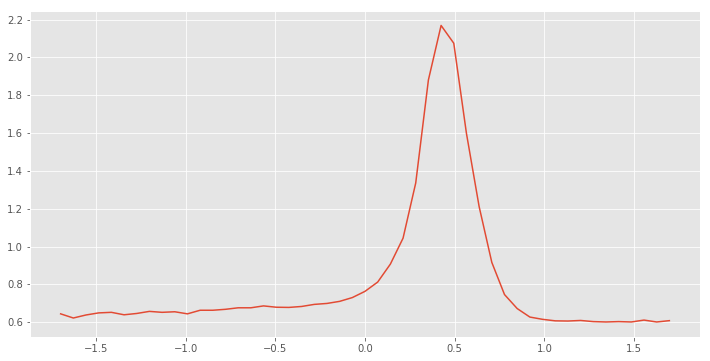

In [4]:
plt.plot(X, y)

## Обучение моделей (2 балла)

Рассмотрите 3 ядра: 
* Линейное
* Полиномиальное (degree = 3, gamma = 6, coef0 = 1)
* RBF (gamma = 6, coef0 = 1)

Во всех случаях установить ширину трубки `epsilon=0.01`

Для каждого из ядер:
1. Пусть `C = np.logspace(-2, 2, 10)`. Постройте графики зависимости ошибки от параметра $C$ (ось графика со значениями параметра $C$ должна быть в логарифмической шкале). Ошибка измеряется как средняя абсолютная ошибка. 
2. Для наулучшего параметра $С$ каждого из ядер постройте график с данными и предстазанием по svm

В каких случаях возникает эффекты недообучения, переобучения?

In [5]:
from sklearn.metrics import mean_absolute_error

In [6]:
## Your Code Here
lin_err = []
poly_err = []
rbf_err = []

for C in np.logspace(-2, 2, 10):
    model = SVR(kernel='linear', C=C)
    model.fit(X, y)
    lin_err.append(mean_absolute_error(model.predict(X), y))
    
    model = SVR(kernel='poly', degree = 3, gamma = 6, coef0 = 1, C=C)
    model.fit(X, y)
    poly_err.append(mean_absolute_error(model.predict(X), y))
    
    model = SVR(kernel='rbf', gamma = 6, coef0 = 1, C=C)
    model.fit(X, y)
    rbf_err.append(mean_absolute_error(model.predict(X), y))

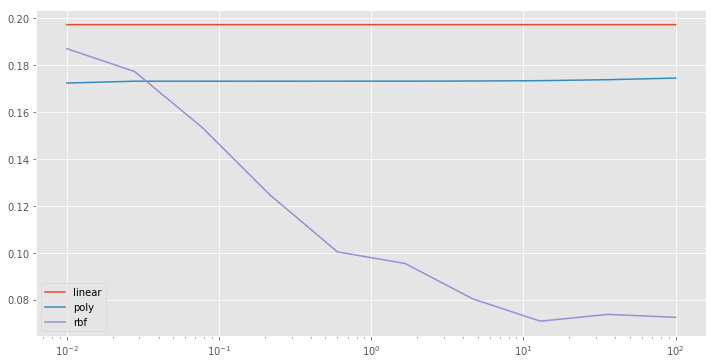

In [7]:
plt.plot(np.logspace(-2, 2, 10), lin_err, label='linear')
plt.plot(np.logspace(-2, 2, 10), poly_err, label='poly')
plt.plot(np.logspace(-2, 2, 10), rbf_err, label='rbf')
plt.legend()
plt.xscale('log')

In [8]:
print np.logspace(-2, 2, 10)[np.argmin(lin_err)]
print np.logspace(-2, 2, 10)[np.argmin(poly_err)]
print np.logspace(-2, 2, 10)[np.argmin(rbf_err)]

100.0
0.01
12.9154966501


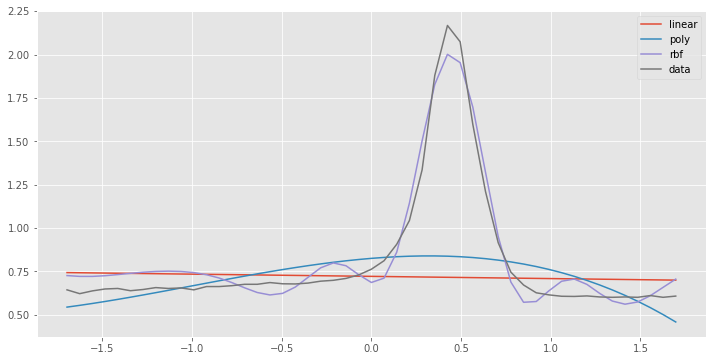

In [9]:
model = SVR(kernel='linear', C=np.logspace(-2, 2, 10)[np.argmin(lin_err)])
model.fit(X, y)
plt.plot(X, model.predict(X), label='linear')
   
model = SVR(kernel='poly', degree=3, gamma=6, coef0=1, C=np.logspace(-2, 2, 10)[np.argmin(poly_err)])
model.fit(X, y)
plt.plot(X, model.predict(X), label='poly')

model = SVR(kernel='rbf', gamma=6, coef0=1, C=np.logspace(-2, 2, 10)[np.argmin(rbf_err)])
model.fit(X, y)
plt.plot(X, model.predict(X), label='rbf')
    
plt.plot(X, y, label='data')
plt.legend()

Полиномиальная недообучилась, у RBF видно небольшое переобучение, но в целом самое лучшее предсказание

# Определение языка слова (7 баллов)

В данном задании вам необходимо определить, на каком языке написано слово.

Вам будет дано два текста - первые предложения произведения "Война и Мир" на английком и испанском, разбитые на слова. У слов нет общепринятого числового представления, поэтому мы предлагаем вам реализовать собственноге ядро для SVM, основанное на редакторском расстоянии или [расстоянии Левинштейна](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B5%D0%B2%D0%B5%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D0%B0). 

Имплементировать расстояние Леванштейна не нужно - можно взять любую доступную реализацию, например [здесь](https://github.com/toastdriven/pylev) или [здесь](https://github.com/ztane/python-Levenshtein).

## Загрузка (1 балл)

Загрузите данные из файлов *war_and_peace_es.txt* и *war_and_peace_en.txt*.<br/> 
В результате вы должны получить pandas.DataFrame со столбцами *index* | *word* | *label*, где *index* - это индекс pandas, *word* - это слово и *label* - это метка класса (0 или 1)

In [10]:
## Your Code Here
df_es = pd.read_csv('war_and_peace_es.txt', header=None)
df_es['1'] = np.ones(df_es.shape[0])

df_en = pd.read_csv('war_and_peace_en.txt', header=None)
df_en['1'] = np.zeros(df_en.shape[0])

df = pd.concat([df_es, df_en]) 
df.columns = ['word', 'label']

In [11]:
# like this
df.head()

,word,label
0,guerra,1.0
1,pace,1.0
2,lev,1.0
3,nicoevic,1.0
4,tolstj,1.0


## Подготовка данных (2 балла)

Особенностью пользовательского ядра в sklean.SVC является то, что на вход оно должно принимать именно вектора чисел.<br/>
В нашем случае это будут индексы соответствующих слов из корпуса. То есть вместо вектора ['treat', 'celebrit', 'prince', ...] на вход в ядро подается вектор из индексов [9209, 11145, 7735, ...] с помощью которых вы будете находить сами слова.

Прежде чем мы начнем строить ядро, надо подготовить данные. Для этого:
1. Задайте переменную RND_SEED, которая будет использоваться в любых генераторах случайных чисел в вашем коде (обычно параметр "random_seed")
2. Случайным образом перемешайте и заново проиндексируйте таблицу, полученную выше (используйте методы df.sample() и df.reset_index())
3. Ядро может вычисляться достаточно долго, поэтому можете урезать таблицу, но оставить в ней не менее 1000 слов.
4. Разбейте данные на обучающую и контрольную выборку в пропорции 60/40

В результате вы должны получить вектор-столбец X_train, X_test с **индексами** слов и векторы y_train, y_test с метками классов.

In [12]:
from sklearn.cross_validation import train_test_split

C:\Users\Ivan\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
RND_SEED = 42
df_sample = df.sample(n=df.shape[0], random_state=RND_SEED)
df_sample = df_sample.reset_index(drop=True)

df_crop = df_sample.iloc[:1000]
X = np.arange(1000)
y = df_crop['label'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=RND_SEED)

## Расчет ядра (3 балла)

Некоторые указания по составлению пользовательского ядра можно найти [здесь](http://stackoverflow.com/questions/26962159/how-to-use-a-custom-svm-kernel).

Если в двух словах:<br/>
Функция, реазлизующая расчет ядра должна принимать две матрицы $U$ и $V$ с признаковым описанием объектов (во време обучения они обе относятся к обучающей выборке, а во время применения - одна матрица относится к обучающей выборке, а другая к контрольной).

В результате, функция должна возвращать матрицу ядра $G_{ij} = K(U_i, V_j)$.

Таким образом, в этом задании вам надо:
1. Написать функцию *string_kernel(U, V)*, расчитывающее матрицу ядра $G_{ij}$
2. Визуализировать матрицу только для обучающей выборки (функция plt.imshow()).

**ВАЖНО**<br/>
На лекции мы рассмотрели, что ядро должно обладать определенными свойствами, поэтому не получится рассчитать $G_{ij}$ как расстояние Левинштейна между словами $\text{word}_i$ и $\text{word}_j$.<br/>
Вместо этого используйте какое-нибудь готовое ядро, зависящее от расстояние между объектами.

In [14]:
def string_kernel(U, V):
    #Your Code Here
    # Ядро RBF, в качестве меры взято расстояние Левенштейна, гамма равно 1, т.к. число свойств = 1
    G = np.zeros((U.shape[0], V.shape[0]))
    for i, u in enumerate(U):
        for j, v in enumerate(V):
            word1 = df_crop.word[u]
            word2 = df_crop.word[v]
            G[i][j] =  np.e**(-distance(word1, word2))
    return G

G = string_kernel(X_train, X_train)

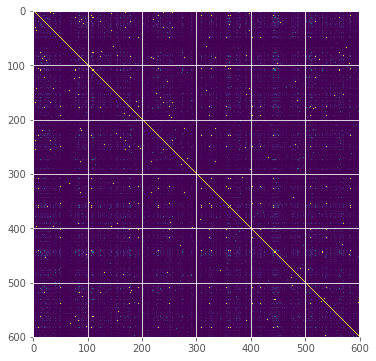

In [15]:
plt.imshow(G)

## Оценка качества (1 балл)

Обучите метод опорных векторов с различными значениями параметра штрафа $C$.<br/>
Для каждого значения выведите accuracy на обучащюей и контрольной выборке.

Постарайтесь достичь качества в 70% на тестовой выборке

In [16]:
from sklearn.metrics import accuracy_score

In [18]:
# Your Code Here
acc_train = []
acc_test = []
for C in np.logspace(-2, 2, 10):
    model = SVC(C=C, kernel='precomputed')
    model.fit(string_kernel(X_train, X_train), y_train)
    
    pred = model.predict(string_kernel(X_train, X_train))
    acc_train.append(accuracy_score(y_train, pred))
    
    pred = model.predict(string_kernel(X_test, X_train))
    acc_test.append(accuracy_score(y_test, pred))    

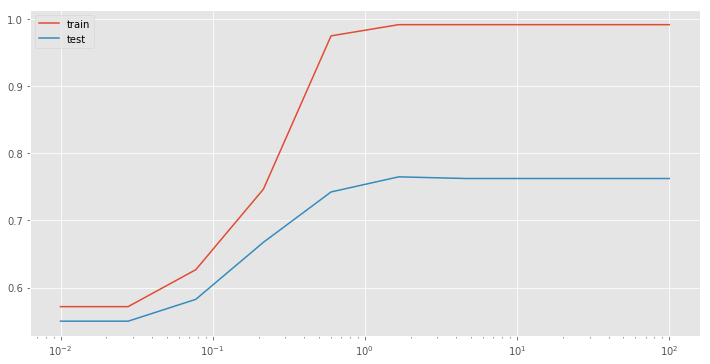

In [19]:
plt.plot(np.logspace(-2, 2, 10), acc_train, label='train')
plt.plot(np.logspace(-2, 2, 10), acc_test, label='test')
plt.legend()
plt.xscale('log')